In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

N = 10_000
h = 64

t = np.arange(N)
noise_scale = 0.3
period = 30
sin_wave = np.sin(2 * np.pi * t / period)
noise = np.random.normal(0, noise_scale, size=N)
target = sin_wave + noise

df = TimeSeriesDataFrame(
    pd.DataFrame(
        {"item_id": 0, "timestamp": pd.date_range("2020-01-01", freq="D", periods=N), "target": target}
    )
)
past = df.slice_by_timestep(None, -h)
future = df.slice_by_timestep(-h, None)

In [10]:
predictor = TimeSeriesPredictor(prediction_length=30, eval_metric="SQL", quantile_levels=[0.01, 0.05, 0.5, 0.95, 0.99])
predictor.fit(past, hyperparameters={
    "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "_default"}},
            {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "_custom"}},
        ]
    },
    enable_ensemble=False,
    time_limit=60
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/home/shchuro/workspace/autogluon/shchuro/AutogluonModels/ag-20250902_085211'
=================== System Info ===================
AutoGluon Version:  1.4.1b20250826
Python Version:     3.12.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Aug  7 19:30:40 UTC 2025
CPU Count:          48
GPU Count:          4
Memory Avail:       347.72 GB / 372.73 GB (93.3%)
Disk Space Avail:   1570.36 GB / 1999.93 GB (78.5%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': SQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': '_default'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': '_custom'},
                                  'fine_tune': True,
                                  'model_path': 'bolt_small'}]},
 'known_covariates_names': [],
 'num_val_windows': 1,
 

	-0.0948       = Validation score (-SQL)
	0.01    s     = Training runtime
	0.88    s     = Validation (prediction) runtime
Training timeseries model Chronos_custom[bolt_small]. Training for up to 59.1s of the 59.1s of remaining time.
	Saving fine-tuned model to /home/shchuro/workspace/autogluon/shchuro/AutogluonModels/ag-20250902_085211/models/Chronos_custom[bolt_small]/W0/fine-tuned-ckpt
	-0.0851       = Validation score (-SQL)
	48.81   s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training complete. Models trained: ['Chronos_default[bolt_small]', 'Chronos_custom[bolt_small]']
Total runtime: 49.73 s
Best model: Chronos_custom[bolt_small]
Best model score: -0.0851


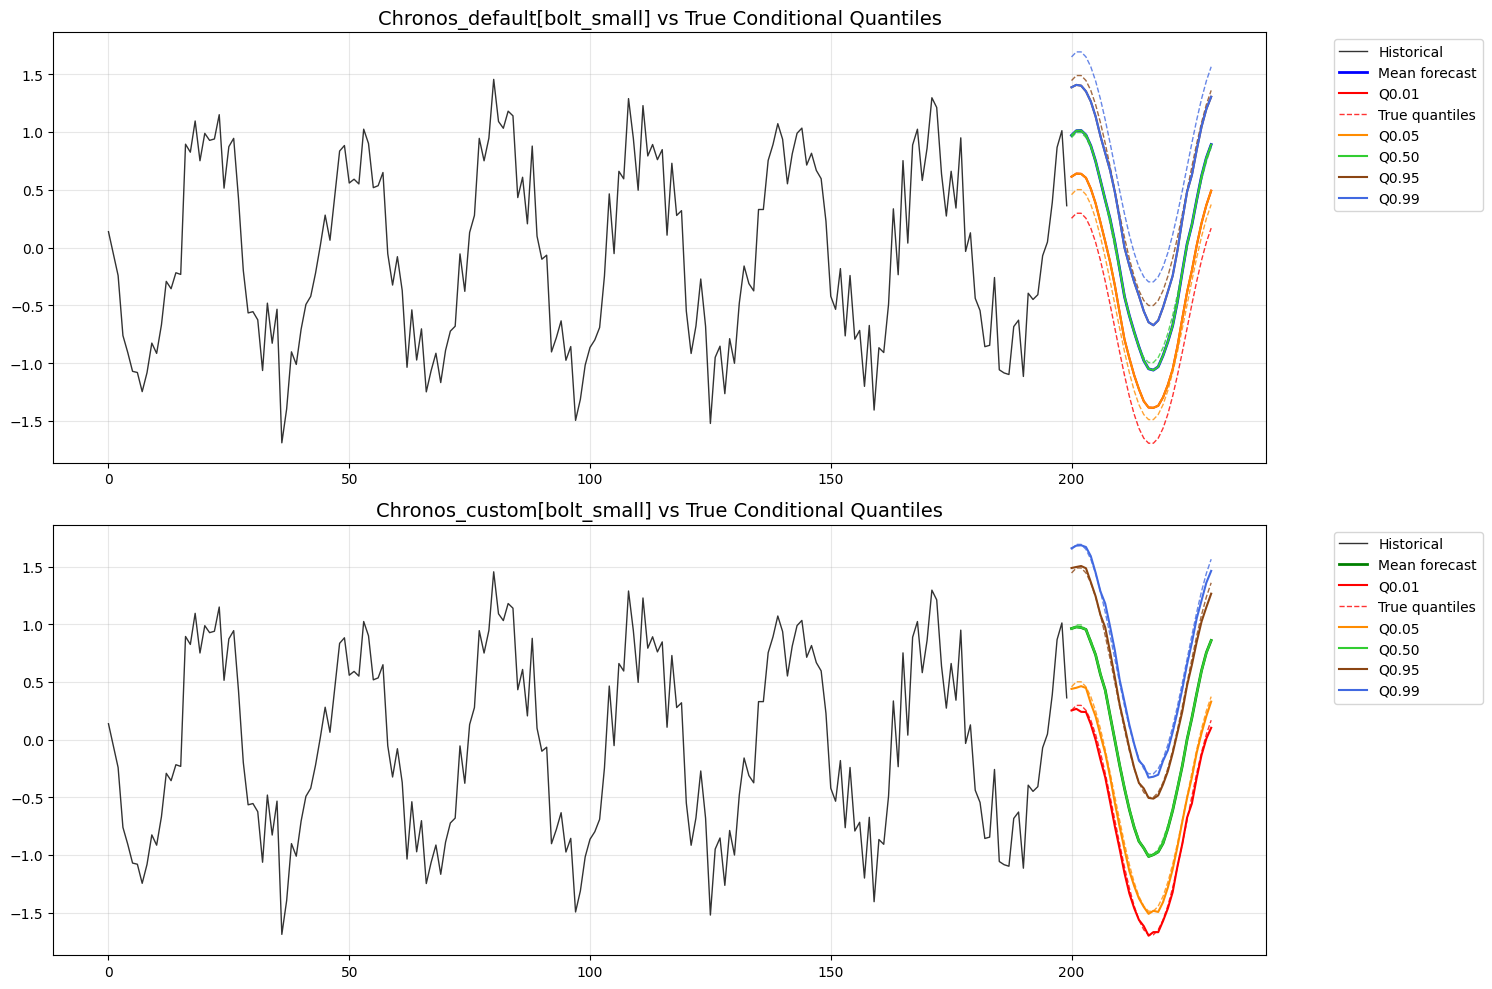

Quantile Level Comparison (last forecast step):
Quantile   True         Chronos_default[bolt_small] Chronos_custom[bolt_small]
----------------------------------------------------------------------
0.01       0.168        0.492                          0.102                         
0.05       0.373        0.492                          0.329                         
0.50       0.866        0.891                          0.860                         
0.95       1.359        1.304                          1.265                         
0.99       1.564        1.304                          1.463                         


In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Get predictions from models
models = ['Chronos_default[bolt_small]', 'Chronos_custom[bolt_small]']
predictions = [predictor.predict(past, model=model) for model in models]

# Calculate theoretical quantiles
h = predictor.prediction_length
true_future_sin = np.sin(2 * np.pi * np.arange(len(past), len(past) + h) / period)
theoretical_quantiles = {}
for q in predictor.quantile_levels:
    theoretical_quantiles[str(q)] = true_future_sin + stats.norm.ppf(q, loc=0, scale=noise_scale)

# Get historical data for plotting
history = past.iloc[-200:].reset_index()
forecast_steps = np.arange(len(history), len(history) + h)

# Create plot
fig, axes = plt.subplots(len(models), 1, figsize=(15, 5*len(models)))
colors = ['#FF0000', '#FF8C00', '#32CD32', '#8B4513', '#4169E1']  # Red, DarkOrange, LimeGreen, SaddleBrown, RoyalBlue

model_colors = ['blue', 'green']

for i, (model, preds) in enumerate(zip(models, predictions)):
    ax = axes[i]

    # Plot historical and true future
    ax.plot(range(len(history)), history['target'], 'k-', label='Historical', alpha=0.8, linewidth=1)
    # ax.plot(forecast_steps, future['target'].values, 'red', label='True future', linewidth=2)
    ax.plot(forecast_steps, preds['mean'], model_colors[i], label='Mean forecast', linewidth=2)

    # Plot quantiles
    for j, q in enumerate(predictor.quantile_levels):
        q_str = str(q)
        ax.plot(forecast_steps, preds[q_str], color=colors[j], label=f'Q{q:.2f}', linewidth=1.5)
        ax.plot(forecast_steps, theoretical_quantiles[q_str], color=colors[j],
                linestyle='--', alpha=0.8, linewidth=1,
                label='True quantiles' if j == 0 else "")

    ax.set_title(f'{model} vs True Conditional Quantiles', fontsize=14)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison table
print("Quantile Level Comparison (last forecast step):")
print(f"{'Quantile':<10} {'True':<12} {models[0]:<20} {models[1]:<20}")
print("-" * 70)
for q in predictor.quantile_levels:
    q_str = str(q)
    true_val = theoretical_quantiles[q_str][-1]
    vals = [preds[q_str].iloc[-1] for preds in predictions]
    print(f"{q:<10.2f} {true_val:<12.3f} {vals[0]:<30.3f} {vals[1]:<30.3f}")
